# CASSI measurement reconstruction using Deep Image Prior (DIP) model

In [1]:
#General imports
import matplotlib.pyplot as plt
import tensorflow as tf
import os
os.chdir(os.path.dirname(os.getcwd()))


# Check GPU support


2023-09-27 21:41:30.817248: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-27 21:41:30.846309: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-27 21:41:30.846772: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-27 21:41:31.358415: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Load Dataset

In [2]:
from colibri_hdsp.data.datasets import Dataset

# example dataset
data_path = 'cifar10'
batch_size = 1
dataset = Dataset(data_path, batch_size)

x_gt, _ = next(iter(dataset.test_dataset))
x_gt = tf.cast(x_gt, tf.float32)
xmin = tf.reduce_min(x_gt); xmax = tf.reduce_max(x_gt)
x_gt = (x_gt - xmin)/(xmax - xmin)
_, M, N, C = x_gt.shape
print("Ground truth image shape: {}".format(x_gt.shape))

Loading dataset:  cifar10
Ground truth image shape: (1, 32, 32, 3)


2023-09-27 21:41:32.552772: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-27 21:41:32.553054: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


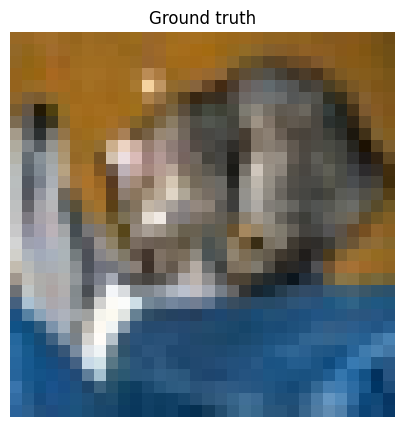

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(x_gt[0, :, :, :])
ax.axis('off')
ax.title.set_text('Ground truth')
plt.show()


## Optics Layer

In [4]:
from colibri_hdsp.optics.cassi import *

mode = 'base' # Type of CASSi optical system
cassi = CASSI(mode) # CASSI layer
cassi.build(x_gt.shape[1:])
y_measurments = cassi(x_gt) # CASSI measurements

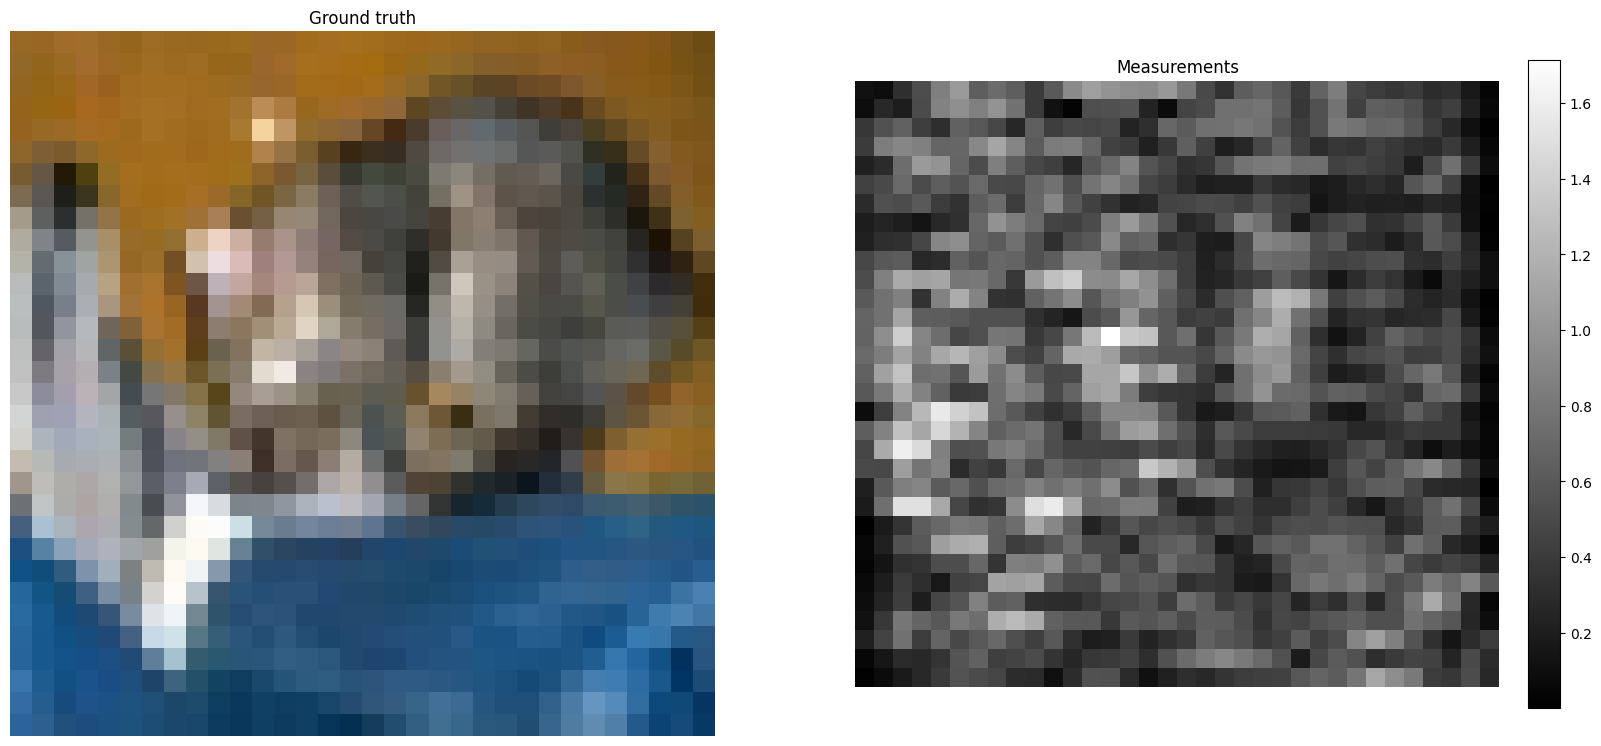

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
ax = axs[0]
ax.imshow(x_gt[0, :, :, :])
ax.axis('off')
ax.title.set_text('Ground truth')
ax = axs[1]
im = ax.imshow(y_measurments[0, :, :, 0], cmap="gray"); 
# Colorbar
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.axis('off')
ax.title.set_text('Measurements')
plt.show()


## DIP model 

In [6]:
from colibri_hdsp.models import DIP_CASSI

network_args = {'features': [28,32,14],'reduce_spatial':False,'out_channels':C,}
model = DIP_CASSI(input_shape=x_gt.shape[1:],recon='autoencoder',initilization='random',network_args=network_args,optical_layer=cassi)
model.compile(optimizer='adam',loss='mean_squared_error')



Epoch 1/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.0482
Epoch 2/1000


1/1 [==============================] - 0s 8ms/step - loss: 0.0518
Epoch 3/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.0532
Epoch 4/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.0544
Epoch 5/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.0538
Epoch 6/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0486
Epoch 7/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0472
Epoch 8/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0537
Epoch 9/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0464
Epoch 10/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.0485
Epoch 11/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.0480
Epoch 12/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.0479
Epoch 13/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.0446
Epoch 14/1000
1/1 [==============================] - 0s 9ms/s

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


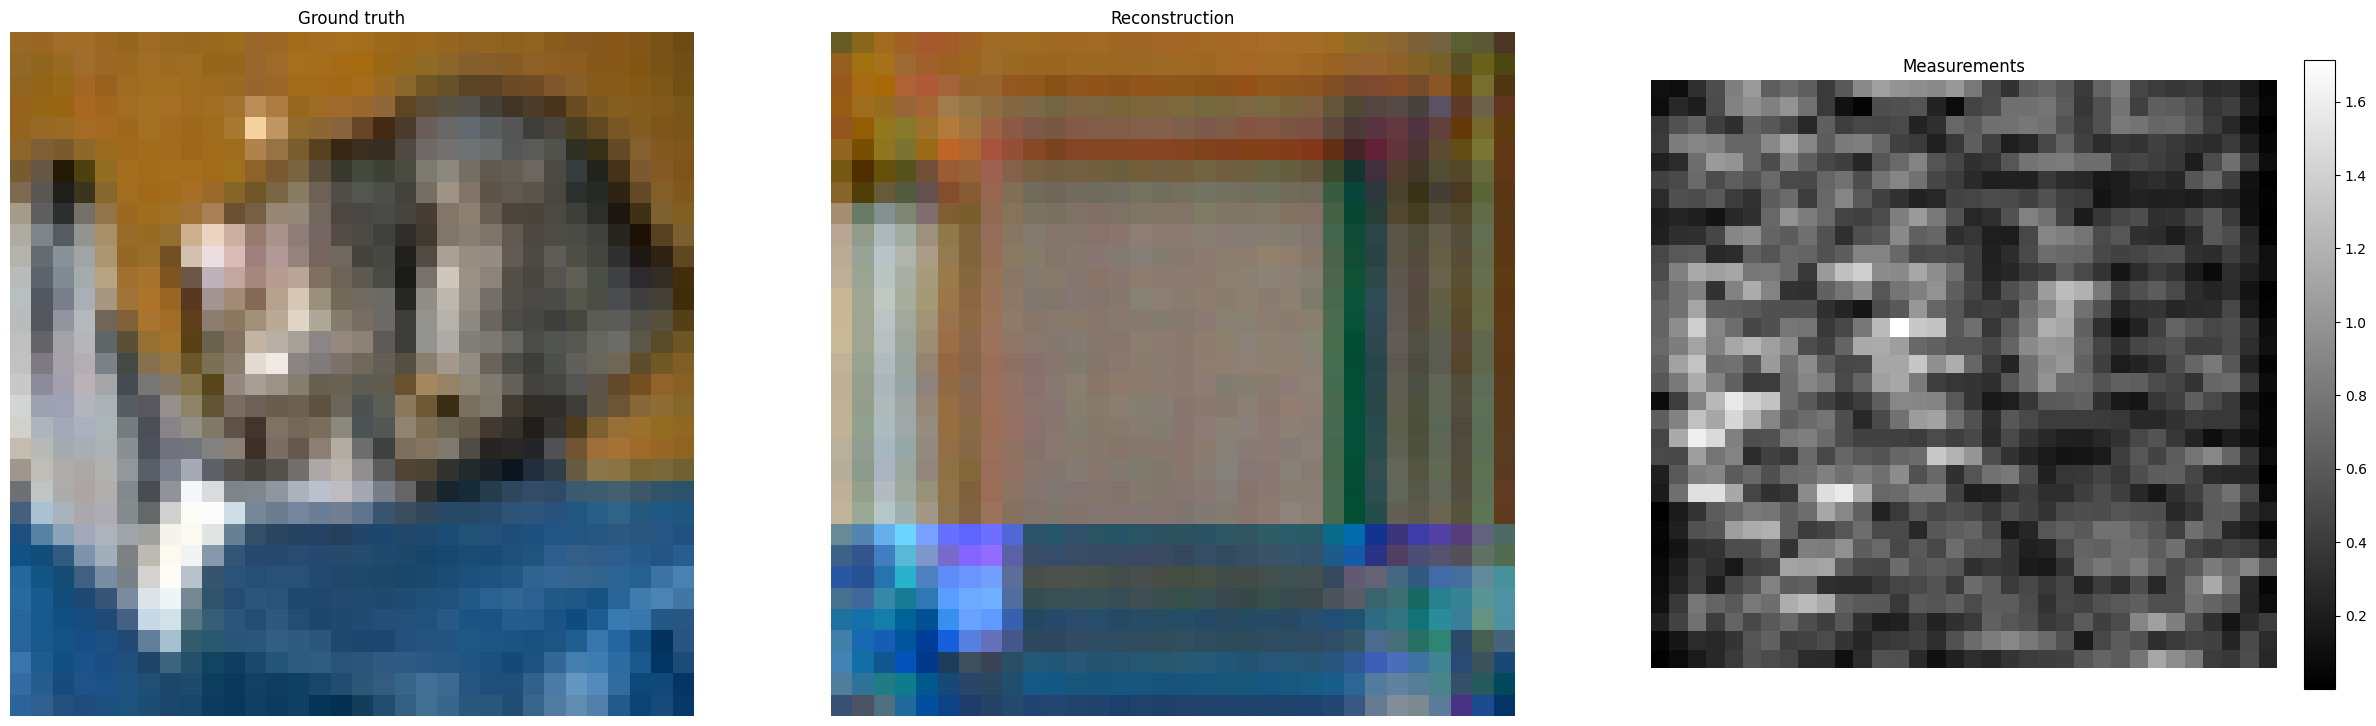

In [12]:
model.fit(x=x_gt,y=y_measurments,epochs=1000, verbose=1)

reconstruction = model(y_measurments, training=False)
fig, axs = plt.subplots(1, 3, figsize=(30, 10))
ax = axs[0]
ax.imshow(x_gt[0, :, :, :])
ax.axis('off')
ax.title.set_text('Ground truth')
ax = axs[1]
im = ax.imshow(reconstruction[0, :, :, :]);
ax.axis('off')
ax.title.set_text('Reconstruction')
ax = axs[2]
im = ax.imshow(y_measurments[0, :, :, 0], cmap="gray"); 
# Colorbar
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.axis('off')
ax.title.set_text('Measurements')
plt.show()
